# Introduction

Three groups: microsatellite instability high (MSI-H), microsatellite instability low (MSI-L) and microsatellite stable (MSS).

Two sets of measurements: 7_marker, 5_marker. The original report consider one sample as MSI if both indicate positive.

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# mpl.rcParams['figure.dpi'] = 600

In [2]:
import sys
sys.path.append("..")
import sensei

In [3]:
df = pd.read_excel("41591_2016_BFnm4191_MOESM27_ESM.xlsx", index=1)
df

,Sample Name,Average difference in microsatellite alleles relative to paired normal,Number Unstable Loci,Number Loci Called,Proportion Unstable Loci,Stability at chr8:7679723-7679741,MOSAIC classification,Tumor Type,MSI-PCR Result,In Training Set?
0,TCGA-GV-A6ZA,-0.000393,510,144859,0.003521,stable,MSS,BLCA,NaN,no
1,TCGA-H4-A2HO,0.001674,1203,244912,0.004912,stable,MSS,BLCA,NaN,no
2,TCGA-H4-A2HQ,0.000091,915,230733,0.003966,stable,MSS,BLCA,NaN,no
3,TCGA-HQ-A2OE,0.000061,526,165003,0.003188,stable,MSS,BLCA,NaN,no
4,TCGA-HQ-A2OF,0.000605,407,128967,0.003156,stable,MSS,BLCA,NaN,no
...,...,...,...,...,...,...,...,...,...,...
5925,TCGA-QS-A8F1,-0.000477,1316,226304,0.005815,stable,MSS,UCEC,ND,no
5926,TCGA-SJ-A6ZI,0.008849,3363,298901,0.011251,unstable,MSI-H,UCEC,ND,no
5927,TCGA-SJ-A6ZJ,0.002213,1610,239070,0.006734,stable,MSS,UCEC,ND,no
5928,TCGA-SL-A6J9,-0.000376,1023,194265,0.005266,stable,MSS,UCEC,ND,no


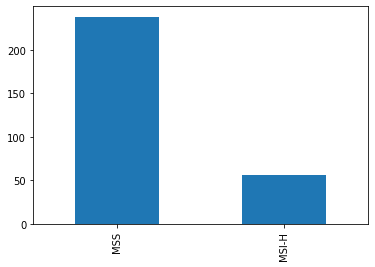

In [4]:
df[df['Tumor Type'] == 'COAD']['MOSAIC classification'].value_counts().plot(kind="bar")

In [5]:
f = lambda x: x[0:3]
msi_mask = (df['MOSAIC classification'] == 'MSI-H') & (df['Tumor Type'] == 'COAD')
mss_mask = (df['MOSAIC classification'] == 'MSS') & (df['Tumor Type'] == 'COAD')

msi_patient_id = df['Sample Name'][msi_mask].to_frame()
mss_patient_id = df['Sample Name'][mss_mask].to_frame()

msi_patient_id['microsatellite'] = 'MSI-H'
mss_patient_id['microsatellite'] = 'MSS'

microsatellite_label_df = msi_patient_id.append(mss_patient_id)

In [6]:
data = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")
data["SampleID"] = data["SampleID"].apply(lambda x: x.replace('.', '-'))
data["PatientID"] = data["SampleID"].apply(lambda x: '-'.join(x.split('-')[0:3]))

In [7]:
merged = data.merge(microsatellite_label_df, left_on="PatientID", right_on='Sample Name')

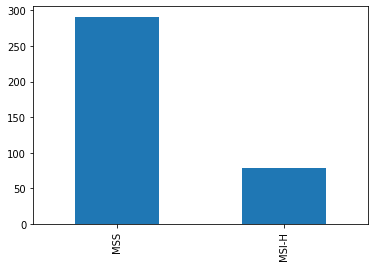

In [8]:
merged.microsatellite.value_counts().plot(kind="bar")

In [9]:
cell_types = ['B.cells.naive', 'B.cells.memory', 'Plasma.cells', 'T.cells.CD8',
       'T.cells.CD4.naive', 'T.cells.CD4.memory.resting',
       'T.cells.CD4.memory.activated', 'T.cells.follicular.helper',
       'T.cells.regulatory..Tregs.', 'T.cells.gamma.delta', 'NK.cells.resting',
       'NK.cells.activated', 'Monocytes', 'Macrophages.M0', 'Macrophages.M1',
       'Macrophages.M2', 'Dendritic.cells.resting',
       'Dendritic.cells.activated', 'Mast.cells.resting',
       'Mast.cells.activated', 'Eosinophils', 'Neutrophils']

#merged['Leukocytes.all'] = merged[cell_types].sum(1)

merged['T.cells.all'] = merged[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

merged['B.cells.all'] = merged[['B.cells.naive', 'B.cells.memory', 'Plasma.cells']].sum(1)

merged['Nk.cells.all'] = merged[['NK.cells.resting', 'NK.cells.activated']].sum(1)

merged['Macrophages.all'] = merged[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

merged['Dendritic.cells.all'] = merged[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

merged['Mast.cells.all'] = merged[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)



augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all']

merged

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,RMSE,PatientID,Sample Name,microsatellite,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
0,TCGA-G4-6317-02A-11R-2066-07,COAD,0.002619,0.067017,0.000000,0.000000,0.035304,0.000000,0.019418,0.000000,...,1.153806,TCGA-G4-6317,TCGA-G4-6317,MSS,0.059557,0.069635,0.022926,0.800711,0.000000,0.047171
1,TCGA-G4-6317-01A-11R-1723-07,COAD,0.005756,0.001784,0.000000,0.613594,0.000000,0.000000,0.119115,0.000753,...,1.142782,TCGA-G4-6317,TCGA-G4-6317,MSS,0.733462,0.007540,0.043908,0.038247,0.011462,0.104174
2,TCGA-G4-6299-01A-11R-1774-07,COAD,0.071421,0.000000,0.014916,0.304882,0.000000,0.000000,0.000000,0.092029,...,1.037898,TCGA-G4-6299,TCGA-G4-6299,MSS,0.426434,0.086337,0.023647,0.415072,0.014984,0.003267
3,TCGA-G4-6303-01A-11R-1774-07,COAD,0.028537,0.000000,0.039905,0.056325,0.000000,0.223052,0.000000,0.011101,...,1.039607,TCGA-G4-6303,TCGA-G4-6303,MSS,0.317433,0.068442,0.025488,0.364759,0.072361,0.113769
4,TCGA-G4-6322-01A-11R-1723-07,COAD,0.037822,0.000000,0.065123,0.044487,0.000000,0.260560,0.000000,0.071790,...,1.038167,TCGA-G4-6322,TCGA-G4-6322,MSS,0.433325,0.102944,0.015860,0.393405,0.000000,0.054466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,TCGA-NH-A8F7-06A-31R-A41B-07,COAD,0.000000,0.054772,0.018013,0.000000,0.153162,0.094355,0.000000,0.000000,...,1.116024,TCGA-NH-A8F7,TCGA-NH-A8F7,MSS,0.247517,0.072785,0.053791,0.554648,0.000000,0.035164
365,TCGA-5M-AAT4-01A-11R-A41B-07,COAD,0.000000,0.074049,0.100050,0.189508,0.000000,0.000000,0.000000,0.132322,...,1.070366,TCGA-5M-AAT4,TCGA-5M-AAT4,MSS,0.321831,0.174099,0.006597,0.289282,0.012516,0.139212
366,TCGA-5M-AAT5-01A-21R-A41B-07,COAD,0.263198,0.000000,0.311417,0.044990,0.000000,0.070022,0.050668,0.083852,...,0.902624,TCGA-5M-AAT5,TCGA-5M-AAT5,MSS,0.249531,0.574615,0.012472,0.111814,0.011270,0.034263
367,TCGA-NH-A8F8-01A-72R-A41B-07,COAD,0.101331,0.000000,0.157118,0.044330,0.000000,0.036854,0.000000,0.078836,...,0.955153,TCGA-NH-A8F8,TCGA-NH-A8F8,MSS,0.173611,0.258449,0.024201,0.488272,0.000000,0.037740


In [10]:
mss = merged[merged.microsatellite == 'MSS'][augmented_cell_types]
msi = merged[merged.microsatellite == 'MSI-H'][augmented_cell_types]

In [11]:
mss

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
0,0.002619,0.067017,0.000000,0.000000,0.035304,0.000000,0.019418,0.000000,0.004834,0.0,...,0.00000,0.047171,0.000000,0.000000,0.059557,0.069635,0.022926,0.800711,0.000000,0.047171
1,0.005756,0.001784,0.000000,0.613594,0.000000,0.000000,0.119115,0.000753,0.000000,0.0,...,0.00000,0.104174,0.008714,0.000000,0.733462,0.007540,0.043908,0.038247,0.011462,0.104174
2,0.071421,0.000000,0.014916,0.304882,0.000000,0.000000,0.000000,0.092029,0.029523,0.0,...,0.00000,0.003267,0.000000,0.000000,0.426434,0.086337,0.023647,0.415072,0.014984,0.003267
3,0.028537,0.000000,0.039905,0.056325,0.000000,0.223052,0.000000,0.011101,0.026954,0.0,...,0.00000,0.113769,0.015796,0.010184,0.317433,0.068442,0.025488,0.364759,0.072361,0.113769
4,0.037822,0.000000,0.065123,0.044487,0.000000,0.260560,0.000000,0.071790,0.056488,0.0,...,0.00000,0.054466,0.000000,0.000000,0.433325,0.102944,0.015860,0.393405,0.000000,0.054466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0.000000,0.054772,0.018013,0.000000,0.153162,0.094355,0.000000,0.000000,0.000000,0.0,...,0.00000,0.035164,0.000000,0.000000,0.247517,0.072785,0.053791,0.554648,0.000000,0.035164
365,0.000000,0.074049,0.100050,0.189508,0.000000,0.000000,0.000000,0.132322,0.000000,0.0,...,0.00000,0.139212,0.013784,0.008563,0.321831,0.174099,0.006597,0.289282,0.012516,0.139212
366,0.263198,0.000000,0.311417,0.044990,0.000000,0.070022,0.050668,0.083852,0.000000,0.0,...,0.00000,0.034263,0.000000,0.000000,0.249531,0.574615,0.012472,0.111814,0.011270,0.034263
367,0.101331,0.000000,0.157118,0.044330,0.000000,0.036854,0.000000,0.078836,0.013591,0.0,...,0.00142,0.036321,0.009367,0.008360,0.173611,0.258449,0.024201,0.488272,0.000000,0.037740


# Results

## MSS

In [12]:
a = 0.05

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

res_mss = pd.DataFrame(index = cell_types, columns = ['mean', 'mean lower', 'mean upper', 'sd', 'sd lower', 'sd upper'])

n = mss.shape[0];

# Mean
res_mss['mean'] = mss.mean(axis=0)

res_mss['sd'] = mss.std(ddof=1, axis=0)
        
# Mean CI
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * res_mss['sd'] / np.sqrt(n)
res_mss['mean lower'] = (res_mss['mean'] - err).apply(sanitize)
res_mss['mean upper'] = (res_mss['mean'] + err).apply(sanitize)
        
# Standard deviation CI
res_mss['sd lower'] = np.sqrt((n - 1) * res_mss['sd'] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
res_mss['sd upper'] = np.sqrt((n - 1) * res_mss['sd'] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

res_mss

,mean,mean lower,mean upper,sd,sd lower,sd upper
B.cells.naive,0.041597,0.034686,0.048508,0.059901,0.055397,0.065207
B.cells.memory,0.018105,0.015252,0.020958,0.024729,0.022870,0.026920
Plasma.cells,0.045886,0.039884,0.051888,0.052019,0.048108,0.056627
T.cells.CD8,0.108070,0.098663,0.117476,0.081526,0.075397,0.088748
T.cells.CD4.naive,0.005562,0.002900,0.008224,0.023074,0.021340,0.025118
T.cells.CD4.memory.resting,0.120813,0.111087,0.130539,0.084295,0.077957,0.091762
T.cells.CD4.memory.activated,0.014282,0.010947,0.017616,0.028899,0.026727,0.031460
T.cells.follicular.helper,0.057546,0.052319,0.062772,0.045299,0.041894,0.049313
T.cells.regulatory..Tregs.,0.031652,0.027927,0.035378,0.032289,0.029861,0.035149
T.cells.gamma.delta,0.000151,0.000010,0.000293,0.001224,0.001132,0.001332


## MSI

In [13]:
a = 0.05

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

res_msi = pd.DataFrame(index = cell_types, columns = ['mean', 'mean lower', 'mean upper', 'sd', 'sd lower', 'sd upper'])

n = msi.shape[0];

# Mean
res_msi['mean'] = msi.mean(axis=0)

res_msi['sd'] = msi.std(ddof=1, axis=0)
        
# Mean CI
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * res_msi['sd'] / np.sqrt(n)
res_msi['mean lower'] = (res_msi['mean'] - err).apply(sanitize)
res_msi['mean upper'] = (res_msi['mean'] + err).apply(sanitize)
        
# Standard deviation CI
res_msi['sd lower'] = np.sqrt((n - 1) * res_msi['sd'] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
res_msi['sd upper'] = np.sqrt((n - 1) * res_msi['sd'] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

res_msi

,mean,mean lower,mean upper,sd,sd lower,sd upper
B.cells.naive,0.038567,0.027189,0.049944,0.050462,0.043597,0.059913
B.cells.memory,0.007907,0.004166,0.011647,0.016589,0.014332,0.019695
Plasma.cells,0.026243,0.018556,0.033930,0.034094,0.029456,0.040479
T.cells.CD8,0.136655,0.116330,0.156980,0.090147,0.077883,0.107030
T.cells.CD4.naive,0.002647,0.000000,0.006200,0.015760,0.013616,0.018712
T.cells.CD4.memory.resting,0.118553,0.099077,0.138030,0.086384,0.074632,0.102563
T.cells.CD4.memory.activated,0.018492,0.011633,0.025350,0.030419,0.026281,0.036117
T.cells.follicular.helper,0.075632,0.064640,0.086624,0.048753,0.042121,0.057884
T.cells.regulatory..Tregs.,0.026924,0.019831,0.034017,0.031459,0.027180,0.037351
T.cells.gamma.delta,0.000546,0.000000,0.001533,0.004376,0.003781,0.005195


## Figures

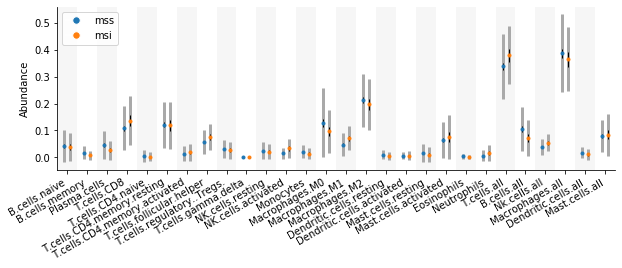

In [14]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 'mss': -0.15,
 'msi': 0.15}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {'mss': colors[0],
 'msi': colors[1]}

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

n = mss.shape[0];
mean = mss.mean(axis=0)
sd = mss.std(ddof=1, axis=0)
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sd / np.sqrt(n)

x = [v + offset_map['mss'] for v in x_map.values()]
    
ax.errorbar(x, mean, yerr=sd, fmt='.', color = color_map['mss'], ecolor = 'darkgray', elinewidth=3.0)
ax.errorbar(x, mean, yerr=err, fmt="None", color = color_map['mss'], ecolor = 'black', elinewidth=1.0)

n = msi.shape[0];
mean = msi.mean(axis=0)
sd = msi.std(ddof=1, axis=0)
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sd / np.sqrt(n)

x = [v + offset_map['msi'] for v in x_map.values()]
    
ax.errorbar(x, mean, yerr=sd, fmt='.', color = color_map['msi'], ecolor = 'darkgray', elinewidth=3.0)
ax.errorbar(x, mean, yerr=err, fmt="None", color = color_map['msi'], ecolor = 'black', elinewidth=1.0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim(current_ylim)
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')

In [15]:
len(cell_types)

22

In [16]:
scipy.stats.skew(msi) < 2

array([False, False,  True,  True, False,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True, False, False,
       False,  True, False, False,  True,  True,  True,  True, False,
        True])

In [17]:
scipy.stats.skewtest(msi)

SkewtestResult(statistic=array([ 6.38749873,  6.11981067,  5.1413163 ,  3.06359293,  9.28684234,
        0.87855239,  6.07782246,  3.11962242,  5.18412532, 10.55472732,
        4.3825784 ,  4.03371604,  5.78868085,  3.65394646,  2.33995951,
        0.86030567,  8.95099097,  8.58753098,  7.75033079,  4.41105592,
        8.9236111 ,  6.58663281,  1.66921949,  5.24555205,  2.9657772 ,
       -1.35977199,  7.30289601,  4.47437638]), pvalue=array([1.68621010e-10, 9.36866046e-10, 2.72820320e-07, 2.18696266e-03,
       1.58933405e-20, 3.79644018e-01, 1.21825525e-09, 1.81082995e-03,
       2.17030976e-07, 4.83040038e-26, 1.17282940e-05, 5.49016579e-05,
       7.09413423e-09, 2.58240135e-04, 1.92858305e-02, 3.89620570e-01,
       3.52305200e-19, 8.88581633e-18, 9.16534770e-15, 1.02867747e-05,
       4.51326599e-19, 4.49913115e-11, 9.50738889e-02, 1.55815064e-07,
       3.01919128e-03, 1.73902089e-01, 2.81638852e-13, 7.66346471e-06]))

In [18]:
scipy.stats.kurtosis(msi)

array([ 7.94958642e+00,  5.21375120e+00,  2.65832022e+00,  8.41154944e-01,
        3.41061954e+01, -7.78990704e-01,  6.55370486e+00,  1.03087792e+00,
        3.73593428e+00,  7.13121631e+01,  1.52047819e+00,  1.70799658e+00,
        6.40980484e+00,  9.51829719e-01,  5.44909437e-01, -3.91873129e-01,
        3.59191191e+01,  2.84992776e+01,  1.58665147e+01,  2.30855211e+00,
        3.42939571e+01,  8.17280041e+00,  1.61841452e-02,  3.02133918e+00,
        1.01309803e+00, -1.67580903e-01,  1.35209706e+01,  2.61436718e+00])

In [19]:
scipy.stats.kurtosistest(msi)

KurtosistestResult(statistic=array([ 4.76858368e+00,  4.10931303e+00,  3.06571980e+00,  1.61965977e+00,
        6.75166523e+00, -1.94905249e+00,  4.46879350e+00,  1.82837567e+00,
        3.58571213e+00,  7.51577377e+00,  2.28749039e+00,  2.43920495e+00,
        4.43405215e+00,  1.74385270e+00,  1.24808662e+00, -5.69862731e-01,
        6.81069478e+00,  6.54049811e+00,  5.78283938e+00,  2.85846671e+00,
        6.75796214e+00,  4.81115511e+00,  3.86568224e-01,  3.25851278e+00,
        1.80965289e+00, -1.42894154e-03,  5.55838300e+00,  3.04091996e+00]), pvalue=array([1.85525613e-06, 3.96837864e-05, 2.17146703e-03, 1.05305382e-01,
       1.46157809e-11, 5.12891560e-02, 7.86620259e-06, 6.74931896e-02,
       3.36159616e-04, 5.65753134e-14, 2.21672158e-02, 1.47196172e-02,
       9.24782430e-06, 8.11847785e-02, 2.11999339e-01, 5.68770804e-01,
       9.71285093e-12, 6.13142705e-11, 7.34501874e-09, 4.25693771e-03,
       1.39946083e-11, 1.50060498e-06, 6.99075886e-01, 1.11997832e-03,
       7.03

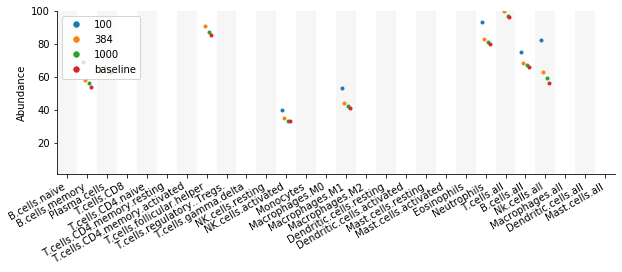

In [20]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 100: -0.2,
 384: -0.1,
 1000: 0.1,
 'baseline': 0.2}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {
 100: colors[0],
 384: colors[1],
 1000: colors[2],
 'baseline': colors[3]}

mem = {100: None,
      384: None,
      1000: None,
      'baseline': None}

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

mss_n = mss.shape[0];
mss_mean = mss.mean(axis=0)
mss_sd = mss.std(ddof=1, axis=0)
mss_err = scipy.stats.t.ppf(1 - a / 2, mss_n - 1) * mss_sd / np.sqrt(mss_n)

msi_n = msi.shape[0];
msi_mean = msi.mean(axis=0)
msi_sd = msi.std(ddof=1, axis=0)
msi_err = scipy.stats.t.ppf(1 - a / 2, msi_n - 1) * msi_sd / np.sqrt(msi_n)

for cell_number in [100, 384, 1000]:
    x = [v + offset_map[cell_number] for v in x_map.values()]
    y = [sensei.optimize.find_minimum_M(10000, cell_number, [m0, m1], [s0, s1], beta=0.2, design='unpaired') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
    ax.errorbar(x, y, yerr=0, fmt='.', color = color_map[cell_number], ecolor = 'darkgray', elinewidth=3.0)
    mem[cell_number] = y
    
x = [v + offset_map['baseline'] for v in x_map.values()]
y = [sensei.optimize.find_minimum_M(10000, cell_number, [m0, m1], [s0, s1], beta=0.2, design='unpaired-baseline') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
ax.errorbar(x, y, yerr=0, fmt='.', color = color_map['baseline'], ecolor = 'darkgray', elinewidth=3.0)
mem['baseline'] = y

import pickle as pkl
with open("msi-mss-coad.pkl", 'wb') as f:
    pkl.dump(mem, f)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim([1, 100])
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')